In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [11]:
# Import data

df = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")
mydata = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv", nrows=10000) #Not selecting full set of rows
test = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv", nrows=3000)#Not selecting full set of rows

In [12]:
# Clean the data
df = df.drop(columns=['cc_num', 'first', 'last', 'gender', 'street', 'zip', 'unix_time'])

# Filtering only the fraud transactions
df = df[df['is_fraud'] == 1] #Why are we doing this?

# Summary
print(df.describe())
print(df.isna().sum())

         Unnamed: 0          amt          lat         long      city_pop  \
count  7.506000e+03  7506.000000  7506.000000  7506.000000  7.506000e+03   
mean   6.249497e+05   531.320092    38.663609   -89.916041  9.727676e+04   
std    4.010560e+05   390.560070     5.172289    14.278221  3.265815e+05   
min    2.449000e+03     1.060000    20.027100  -165.672300  2.300000e+01   
25%    2.398565e+05   245.662500    35.056100   -96.701000  7.465000e+02   
50%    6.381620e+05   396.505000    39.433600   -86.691900  2.623000e+03   
75%    9.849215e+05   900.875000    42.073175   -79.941600  2.143700e+04   
max    1.295733e+06  1376.040000    66.693300   -68.556500  2.906700e+06   

         merch_lat   merch_long  is_fraud  
count  7506.000000  7506.000000    7506.0  
mean     38.653901   -89.915808       1.0  
std       5.218387    14.298685       0.0  
min      19.425114  -166.550779       1.0  
25%      35.114671   -96.671038       1.0  
50%      39.427008   -86.813044       1.0  
75%    

In [13]:
print(df.head())

      Unnamed: 0 trans_date_trans_time                          merchant  \
2449        2449   2019-01-02 01:06:37            fraud_Rutherford-Mertz   
2472        2472   2019-01-02 01:47:29  fraud_Jenkins, Hauck and Friesen   
2523        2523   2019-01-02 03:05:23            fraud_Goodwin-Nitzsche   
2546        2546   2019-01-02 03:38:03            fraud_Erdman-Kertzmann   
2553        2553   2019-01-02 03:55:47                fraud_Koepp-Parker   

           category     amt           city state      lat     long  city_pop  \
2449    grocery_pos  281.06  Collettsville    NC  35.9946 -81.7266       885   
2472  gas_transport   11.52    San Antonio    TX  29.4400 -98.4590   1595797   
2523    grocery_pos  276.31    San Antonio    TX  29.4400 -98.4590   1595797   
2546  gas_transport    7.03  Collettsville    NC  35.9946 -81.7266       885   
2553    grocery_pos  275.73    San Antonio    TX  29.4400 -98.4590   1595797   

                           job         dob                    

In [14]:
# Analyze the relation among category, amount, and fraud
purchase = df[['amt', 'category', 'is_fraud']]
print(purchase.head())
print(purchase.columns)

         amt       category  is_fraud
2449  281.06    grocery_pos         1
2472   11.52  gas_transport         1
2523  276.31    grocery_pos         1
2546    7.03  gas_transport         1
2553  275.73    grocery_pos         1
Index(['amt', 'category', 'is_fraud'], dtype='object')


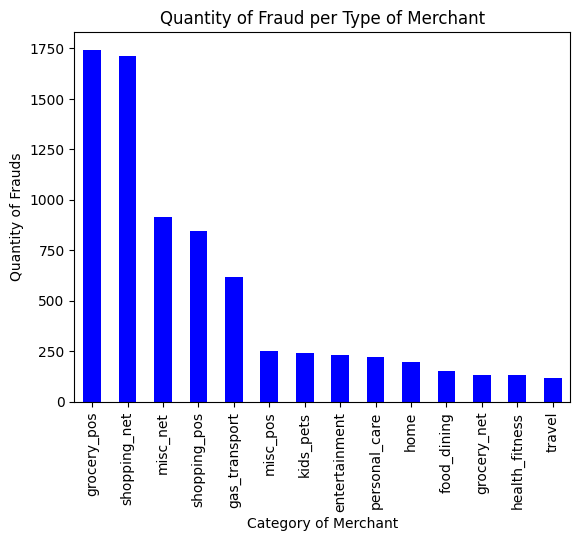

In [15]:
# Create histogram of category of merchants and number of frauds
purchase['category'].value_counts().plot(kind='bar', color='blue')
plt.title('Quantity of Fraud per Type of Merchant')
plt.xlabel('Category of Merchant')
plt.ylabel('Quantity of Frauds')
plt.show()

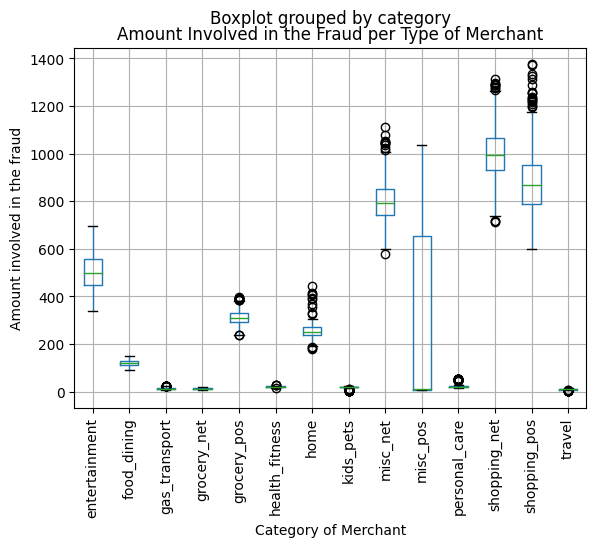

In [16]:
# Create boxplot of category of merchants and amount involved in the fraud
purchase.boxplot(column='amt', by='category')
plt.title('Amount Involved in the Fraud per Type of Merchant')
plt.xlabel('Category of Merchant')
plt.xticks(rotation=90)
plt.ylabel('Amount involved in the fraud')
plt.show()

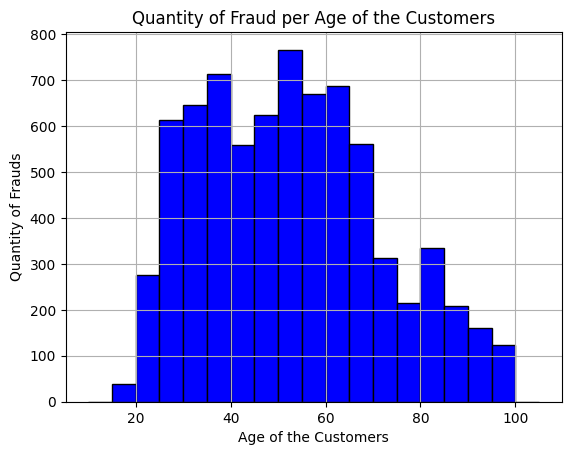

In [17]:
# Create histogram of age of customers and quantity of frauds
df['dob'] = pd.to_datetime(df['dob'])
df['Age'] = ((datetime.now() - df['dob']).dt.days)//365
age = df[['Age', 'is_fraud', 'amt']]

# Creating Bin for the Age Columns
age['Age'].hist(bins=np.arange(10, 110, 5), color='blue', edgecolor='black')
plt.title('Quantity of Fraud per Age of the Customers')
plt.xlabel('Age of the Customers')
plt.ylabel('Quantity of Frauds')
plt.show()

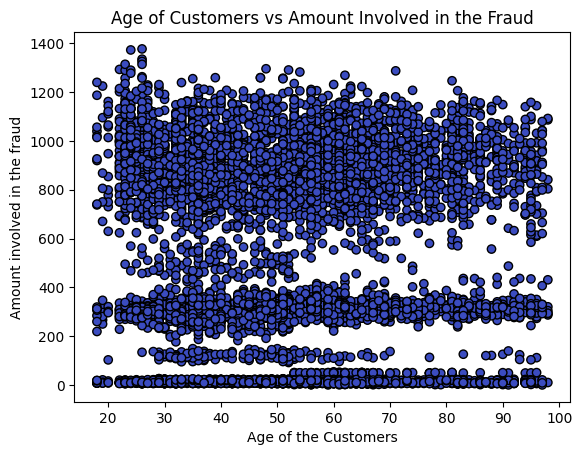

In [18]:
# Create scatterplot of age of customers and amount involved in the fraud
new_df = age[age['is_fraud'] == 1]
age_bins = pd.cut(df['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], include_lowest=True)
df['age_bins'] = age_bins
plt.scatter(df['Age'], df['amt'], c=df['is_fraud'], cmap='coolwarm', edgecolors='k')
plt.title('Age of Customers vs Amount Involved in the Fraud')
plt.xlabel('Age of the Customers')
plt.ylabel('Amount involved in the fraud')
plt.show()

In [19]:
# Recreate age column
mydata['dob'] = pd.to_datetime(mydata['dob'])
mydata['Age'] = ((datetime.now() - mydata['dob']).dt.days)//365

# View the first few rows of the data
print(mydata.head())

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      long city_pop  \
0    Banks      F                561 Perry Cove  ...  -81.1781     3495   
1     Gill      F  43039 Riley Greens Suite 393  ... -11

In [20]:
# Delete unnecessary data
mydata = mydata[['cc_num', 'category', 'amt', 'gender', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'Age']]



In [23]:
# Converting Categorical values to numerical labels
unique_category = mydata['category'].unique()
unique_gender = mydata['gender'].unique()

print(mydata['category'])

0            misc_net
1         grocery_pos
2       entertainment
3       gas_transport
4            misc_pos
            ...      
9995      grocery_net
9996      grocery_pos
9997     shopping_pos
9998      grocery_pos
9999      grocery_pos
Name: category, Length: 10000, dtype: object


In [24]:
# Creating a function to use the which function over a column
# Category
def pm1(x):
    return np.where(unique_category == x)[0][0]

# Genders
def pm2(x):
    return np.where(unique_gender == x)[0][0]

mydata['category'] = mydata['category'].apply(pm1)
mydata['gender'] = mydata['gender'].apply(pm2)

In [25]:
print(mydata['category'])

0       0
1       1
2       2
3       3
4       4
       ..
9995    5
9996    1
9997    7
9998    1
9999    1
Name: category, Length: 10000, dtype: int64


In [26]:
# Creating a decision tree model
X_train = mydata.drop(columns=['is_fraud'])
y_train = mydata['is_fraud']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

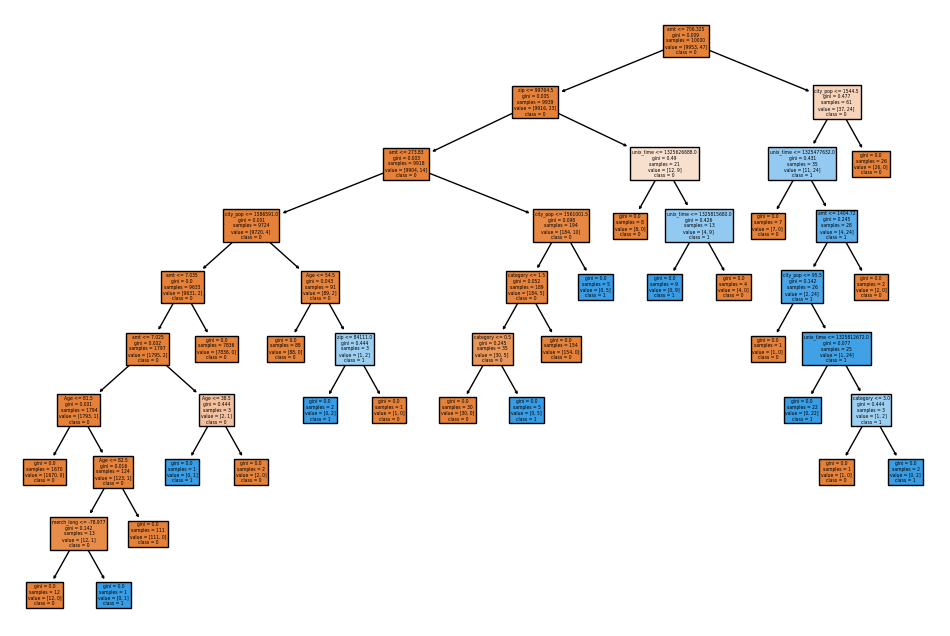

In [27]:
# Plot decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X_train.columns, class_names=['0', '1'], filled=True)
plt.show()

In [28]:
# Creating a logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.015566
         Iterations 18
                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.4791
Time:                        15:46:52   Log-Likelihood:                -155.66
converged:                       True   LL-Null:                       -298.82
Covariance Type:            nonrobust   LLR p-value:                 9.105e-62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cc_num      -2.02e-16   9.63e-17     -2.098      0.036   -3.91e-16   -1.33e-17
category      -0.1840      0

/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [29]:
# Testing decision tree model
test['dob'] = pd.to_datetime(test['dob'])
test['Age'] = ((datetime.now() - test['dob']).dt.days)//365
test = test[['cc_num', 'category', 'amt', 'gender', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'Age']]

# Apply the same labels which were used in Training data
test['category'] = test['category'].apply(pm1)
test['gender'] = test['gender'].apply(pm2)

In [30]:
X_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']


# Predicting values with decision tree ML Model
dt_pred = dt.predict(X_test)

# Predicting values with logistic regression ML Model
lr_pred = result.predict(X_test)


print(pd.crosstab(dt_pred, y_test, rownames=['Predicted'], colnames=['Actual']))
#print(pd.crosstab(lr_pred, y_test, rownames=['Predicted'], colnames=['Actual']))

Actual        0   1
Predicted          
0          2981  15
1             1   3


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
